In [1]:
import numpy as np
import numba
from numba.types import *
from numba import prange
import matplotlib.pyplot as plt
from numpy.linalg import eig, multi_dot, inv
from numpy import sin
from numpy import pi
from scipy.optimize import curve_fit
from scipy.linalg import schur
import matplotlib as mpl
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['font.size']=20
from scipy.linalg import expm
from numpy.linalg import matrix_power
from scipy.stats import linregress
from mpl_toolkits.mplot3d import Axes3D
from scipy.special import gamma

In [2]:
S=250
dim=int(2*S+1)
τ=1
k=5
p=np.pi/2
i=complex(0, 1)
basis = np.identity(dim)
#N_av=100
#h_eff=1/(S)
#β=1

In [3]:
#Definition of the ladder operators
@numba.jit(numba.types.Tuple((float64, float64[:]))(float64[:], float64), nopython=True, fastmath=True, parallel=False)
def S_p(ket, S):
    site= np.argmax(ket)
    m=site-S
    ket_out=np.zeros(dim)
    if site== 2*S:
        coef=0
        return (coef, ket_out)
    else:
        coef=np.sqrt(S*(S+1)-m*(m+1))
        ket_out[site+1]= 1
        return (coef, ket_out)
@numba.jit(numba.types.Tuple((float64, float64[:]))(float64[:], float64), nopython=True, fastmath=True, parallel=False)
def S_m(ket, S):
    site= np.argmax(ket)
    m=site-S
    ket_out=np.zeros(dim)
    if site== 0:
        coef=0
        return (coef, ket_out)
    else:
        coef= np.sqrt(S*(S+1)-m*(m-1))
        ket_out[site-1]= 1
        return (coef, ket_out)

In [4]:
@numba.jit(float64(float64[:], float64[:]), nopython=True, fastmath=True, parallel=False)
def braket(bra, ket):
    if np.all(bra== ket):
        return 1
    else:
        return 0

In [5]:
@numba.jit(float64[:,:](float64[:, :], float64), nopython=True, fastmath=True, parallel=False)
def Compute_Sx(basis, S):
    dim=int(2*S+1)
    Sx=np.zeros((dim, dim))
    for j in range(dim):
        for k in range(dim):
            ket=basis[j, :]
            bra=basis[k, :]
            coef_p, S_p_ket=S_p(ket, S)
            coef_m, S_m_ket=S_m(ket, S)
            result_p=braket(bra, S_p_ket)
            result_m=braket(bra, S_m_ket)
            Sx[j, k]=(coef_p*result_p+ coef_m*result_m)/2
    return Sx

@numba.jit(complex128[:,:](float64[:, :], float64), nopython=True, fastmath=True, parallel=False)
def Compute_Sy(basis, S):
    dim=int(2*S+1)
    Sy=np.zeros((dim, dim), dtype=complex128)
    i=complex(0,1)
    for j in range(dim):
        for k in range(dim):
            ket=basis[j, :]
            bra=basis[k, :]
            coef_p, S_p_ket=S_p(ket, S)
            coef_m, S_m_ket=S_m(ket, S)
            result_p=braket(bra, S_p_ket)
            result_m=braket(bra, S_m_ket)
            Sy[j, k]=-i*(coef_p*result_p- coef_m*result_m)/2
    return Sy

@numba.jit(float64[:,:](float64), nopython=True, fastmath=True, parallel=False)
def Compute_Sz(S):
    dim=int(2*S+1)
    Sz=np.zeros((dim, dim))
    for j in range(dim):
        m=j-S
        Sz[dim-1-j, dim-1-j]=m
    return Sz
def BrodyDist(s, br):
    b=(gamma((br+ 2)/(br + 1)))**(br + 1)
    return (br + 1)*b*s**br*np.exp(-b*s**(br+1))
def unfoldSpectrum(E, order, n_bins, N):
    Emax=np.max(E)
    Emin=np.min(E)
    rhoE, bins=np.histogram(E, bins=np.linspace(Emin, Emax, n_bins+1), density='True')
    bins=bins[:-1]
    N_E=np.zeros(n_bins)
    dummyE=0
    dE=(bins[1]-bins[0])
    for k in range(n_bins):
        dummyE+=rhoE[k]*dE
        N_E[k]=dummyE
    fit=np.polyfit(bins, N_E, order)
    polyn=np.poly1d(fit)
    unf_E=N*polyn(E)
    rhoE_unf, bins=np.histogram(unf_E, bins=np.linspace(np.min(unf_E), np.max(unf_E), n_bins+1), density='True')
    stdrho=np.std(rhoE_unf)
    #plt.bar(bins[:-1], rhoE_unf, width=(bins[1]-bins[0]))
    #plt.hlines(1/N+2*stdrho, 0, N)
    #plt.hlines(1/N-2*stdrho, 0, N)
    #plt.show()
    ndiscard=np.sum(rhoE_unf>1/N+2*stdrho) # # bins with ρ(E)>1/N+2σ. # bins to discard
    #print(ndiscard)
    unf_E=unf_E[unf_E>bins[ndiscard]]
    unf_E=unf_E[unf_E<bins[-1-ndiscard]]
    return unf_E
#@numba.njit()
def compute_s(U):
    eval_U=np.linalg.eigvals(U)
    logeval=np.log(eval_U)/i
    aux=np.real(logeval)
    idx=np.argsort(aux)
    E=aux[idx] #from -π to +π
    unf_E=unfoldSpectrum(E, order_polyn, n_bins, dim)
    s_list=np.diff(unf_E)
    return s_list

In [6]:
Sx=np.zeros((dim, dim))
Sy=np.zeros((dim, dim), dtype=complex)
Sx=Compute_Sx(basis, S)
Sy=Compute_Sy(basis, S) #I've checked that for S=1/2, 1, 3/2 the results are the expected ones
Sz=Compute_Sz(S)

In [7]:
order_polyn=10
n_bins=70
tx=0
ax=1
ty=0
ay=1
#tz=10
az=1
n_points_k=25
n_min=0
n_max=30
step_n=1
n_array=np.arange(n_min, n_max, step_n)
k_min=0
k_max=20
"""
k_aux=np.linspace(np.log10(k_min), np.log10(k_max), n_points_k)
k_arr=10**k_aux"""
k_arr=np.linspace(k_min, k_max,n_points_k )
pseudoE=np.zeros((n_points_k, dim))
s_list=np.zeros(n_points_k*(dim-1))
#Z_beta=np.zeros(n_points_beta)
#DeltaE_beta=np.zeros(n_points_beta)
ind=0
lyapvsk=np.zeros((n_points_k, n_points_k))
brody_p=np.zeros((n_points_k, n_points_k))
#sigma_lyap=np.zeros(n_points_k)
W=Sx
F_OTOC=np.zeros(len(n_array), dtype=complex)
for j in range(n_points_k):
    for l in range(n_points_k):
        #U=expm(i*k_arr[j]*Sz@Sz/(2*S))@expm(-i*p*Sy)@expm(-i*k_arr[j]*Sz@Sz/(2*S))@expm(-i*p*Sy)
        #U=expm(-i*k_arr[j]*Sz@Sz/(2*S))@expm(-i*p*Sy)
        #U=expm(i*p*Sz-i*k_arr[j]*Sz@Sz/(2*S))@expm(-i*p*Sy)
        U=expm(-i*k_arr[j]*Sz@Sz/dim-i*az*Sz)@expm(-i*ty*Sy@Sy/dim-i*ay*Sy)@expm(-i*k_arr[l]*Sx@Sx/dim-i*ax*Sx)
        s_list=compute_s(U)
        hist, bins=np.histogram(s_list, bins=40, density=True)
        brody_p[j,l], pcov=curve_fit(BrodyDist, bins[:-1]+(bins[1]-bins[0])/2, hist, p0=0.9)
        invU=inv(U)
        U_n=np.identity(dim)
        invU_n=np.identity(dim)
        for j_loop in range(len(n_array)):
            W_t=invU_n@W@U_n
            commX=Sx@W_t-W_t@Sx
            commY=Sy@W_t-W_t@Sy
            commZ=Sz@W_t-W_t@Sz
            F_OTOC[j_loop]= -1/(2*S+1)*(np.trace(commX@commX)+np.trace(commY@commY)+np.trace(commZ@commZ))
            U_n=U_n@U
            invU_n=invU_n@invU
        logF=np.log(F_OTOC)-np.log(F_OTOC[0])
        cutoff=0.7*np.max(logF)
        F_fit=np.abs(logF[logF<cutoff])
        t_fit=n_array[logF<cutoff]
        res=linregress(t_fit, F_fit)
        lyapvsk[j, l]=res.slope
        #sigma_lyap[j]=res.stderr

/home/pablo/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/pablo/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/pablo/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


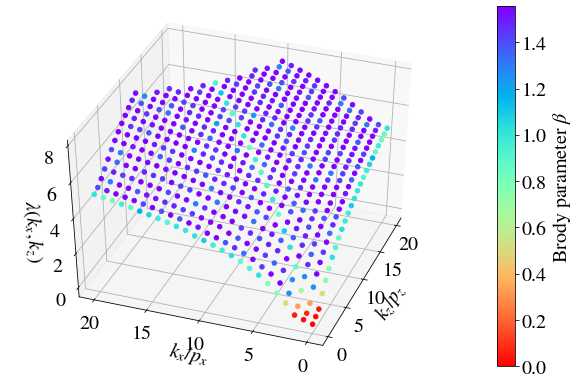

In [9]:
s=np.linspace(0,5, 100)
betaGUE, _=curve_fit(BrodyDist, s, 32*s**2/np.pi**2*np.exp(-4*s**2/np.pi) , p0=1)
#print(brody_p[:,:])
X, Y=np.meshgrid(k_arr, k_arr)
fig = plt.figure(figsize=[8,5])
axes = Axes3D(fig)
cmap1=mpl.cm.get_cmap('rainbow_r')
for j in range(n_points_k):
    surf=axes.scatter(X[:,j]/az, Y[:,j]/ax, lyapvsk[:,j], c=brody_p[:,j], depthshade=False, cmap=cmap1, vmin=0, vmax=betaGUE)
    
#ax.set_yscale('log')
#surf.clim(0, 1.5)
cb=fig.colorbar(surf)
cb.set_label(r"Brody parameter $\beta$")
axes.view_init(40, 200)
axes.set_xlabel(r"$k_z/p_z$")
axes.set_ylabel(r"$k_x/p_x$")
axes.set_zlabel(r"$\lambda(k_x, k_z)$")
plt.show()

In [ ]:
np.savetxt("QKTGUE_Lyap_pxpz_X.txt", X)
np.savetxt("QKTGUE_Lyap_pxpz_Y.txt", Y)
np.savetxt("QKTGUE_Lyap_pxpz_.txt", lyapvsk)
np.savetxt("QKTGUE_Lyap_pxpz_X.txt", brody_p)